In [1]:
%matplotlib inline


# Restricted Boltzmann Machine features for digit classification

For greyscale image data where pixel values can be interpreted as degrees of
blackness on a white background, like handwritten digit recognition, the
Bernoulli Restricted Boltzmann machine model (:class:`BernoulliRBM
<sklearn.neural_network.BernoulliRBM>`) can perform effective non-linear
feature extraction.


In [2]:
# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

## Generate data

In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data with
linear shifts of 1 pixel in each direction.



In [13]:
import numpy as np

from scipy.ndimage import convolve

from sklearn import datasets
from sklearn.preprocessing import minmax_scale

from sklearn.model_selection import train_test_split


def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, "float32")
X, Y = nudge_dataset(X, y)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

1797


## Models definition

We build a classification pipeline with a BernoulliRBM feature extractor and
a :class:`LogisticRegression <sklearn.linear_model.LogisticRegression>`
classifier.



In [4]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

## Training

The hyperparameters of the entire model (learning rate, hidden layer size,
regularization) were optimized by grid search, but the search is not
reproduced here because of runtime constraints.



In [62]:
from sklearn.base import clone

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.57, time = 0.25s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.68, time = 0.36s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.74, time = 0.26s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.92, time = 0.31s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.70, time = 0.26s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.03, time = 0.39s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.90, time = 0.23s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.47, time = 0.24s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.56, time = 0.24s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.18, time = 0.24s


LogisticRegression(C=100.0, solver='newton-cg', tol=1)

## Evaluation



In [6]:
from sklearn import metrics

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.90      0.95      0.92       184
           2       0.94      0.95      0.94       166
           3       0.95      0.89      0.92       194
           4       0.96      0.95      0.95       186
           5       0.94      0.92      0.93       181
           6       0.98      0.97      0.97       207
           7       0.93      0.99      0.96       154
           8       0.91      0.88      0.90       182
           9       0.88      0.92      0.90       169

    accuracy                           0.94      1797
   macro avg       0.94      0.94      0.94      1797
weighted avg       0.94      0.94      0.94      1797




In [7]:
Y_pred = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       174
           1       0.60      0.58      0.59       184
           2       0.76      0.85      0.80       166
           3       0.78      0.79      0.78       194
           4       0.82      0.84      0.83       186
           5       0.77      0.76      0.76       181
           6       0.90      0.87      0.89       207
           7       0.85      0.88      0.87       154
           8       0.67      0.58      0.62       182
           9       0.75      0.76      0.75       169

    accuracy                           0.78      1797
   macro avg       0.78      0.78      0.78      1797
weighted avg       0.78      0.78      0.78      1797




The features extracted by the BernoulliRBM help improve the classification
accuracy with respect to the logistic regression on raw pixels.



## Plotting



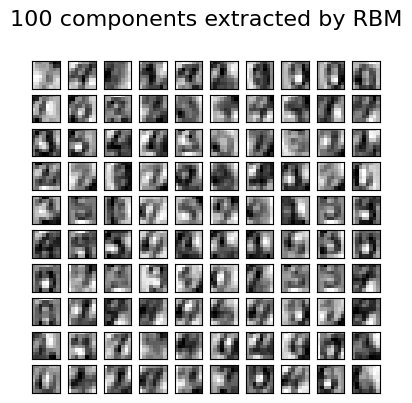

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

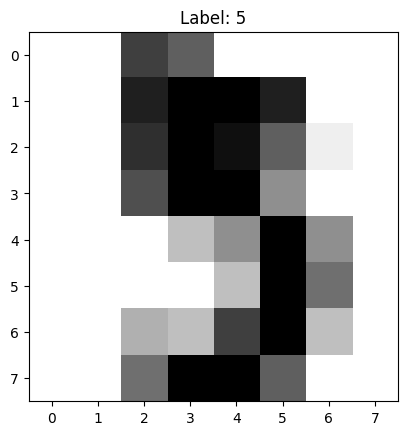

Predicted digit: 5


In [78]:
import random

digits = datasets.load_digits()

# Get one of the images and its label
image_index = random.randint(0, len(digits))
image = digits.images[image_index]
label = digits.target[image_index]

# Display the image and its label
plt.imshow(image, cmap=plt.cm.gray_r)
plt.title('Label: %i' % label)
plt.show()

# Flatten the image into a 1D array
image_flat = image.reshape(1,-1)

predicted_digit = rbm_features_classifier.predict(image_flat)

print('Predicted digit: %i' % predicted_digit)

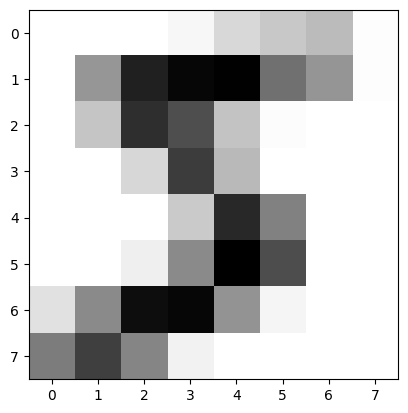

Predicted digit: 5


In [74]:
from PIL import Image

# Wczytanie obrazka i przetworzenie go do formatu 8x8 pikseli
img = Image.open('digits2.jpg').convert('L')
img = img.resize((8, 8))
img_arr = np.array(img, dtype='float32').ravel() / 255.0
img_arr = img_arr.reshape(1,-1)

# Użycie wyuczonych modeli do przewidywania cyfry
rbm_pred = rbm_features_classifier.predict(img_arr)

plt.imshow(img, cmap='gray') # wyświetl obrazek w skali szarości
plt.show()

print(f"Predicted digit: {rbm_pred[0]}")